# Active-learning tutorial: zundel cation

<!-- In this tutorial, we will be preparing and working with a **committee of MACE models** to describe two different **protonated water clusters** in the gas phase and illustrate the important aspects of committee-based active learning using **query by committee (QbC)**.

In the first part, we will leverage the accessible uncertainty measure to screen a wide pool of candidate geometries originating from a DFT simulation of the **Zundel cation** (H$_5$O$_2^+$) to **create a robust and concise training data set**.

In the second part, we will use the obtained model to perform an **exploratory simulation** of the related **Eigen cation** (H$_9$O$_3^+$) and, once again, rely on active learning to select the most relevant training structures
in order for the model to gain accuracy on a new, unexplored part of the configuration space. -->

In this tutorial we will generate a committee of Machine Learning Interatomic Potentials (MLIPs) to run Moleculad Dynamics on the **Zundel cation** (H$_5$O$_2^+$).

To train the models, we will use the Active-Learning method called Query by Committee (QbC) starting from labeled data (**regime 1**), i.e. a dataset of zundel cation structures with energy and forces already provided (computed from DFT using `FHI-aims`, and revPBE+D3 functional).

In [1]:
# ! ase gui ../initial-datasets/zundel/train.extxyz

In [2]:
from ase.io import read
from ase.visualize import view
view(read('../initial-datasets/zundel/train.extxyz', index=0), viewer='x3d')

## Structure of the tutorial

The tutorial will be structured as follows  (~45 minutes):

- **Preparing and evaluating committee MACE models** (~10 minutes):
    - selection of initial training, test datasets and candidate pool
    - then train the initial MACE models
    - analysis of the committee disagreement and the generalization error

- **Query by Committee** (~15 minutes):
    - run QbC (schematic representation in the figure below)
    - monitor of the committee disagreement and generalization error at varying QbC iteration

- **Comparison with random selection** (~10 minutes):
    - train model using randomly selected structures
    - compare with QbC results

<figure style="text-align: center;">
    <img src="images/QbC.png" alt="QbC diagram" style="width: 100%; max-width: 400px;">
    <figcaption style="font-style: italic; font-size: 90%;">
        Schematic representation of Query by Committee (QbC) active learning scheme, 
        showing the candidate pool and training pool selected based on committee uncertainty.
    </figcaption>
</figure>

<span style="color:red">**Attention!**</span> 

We have provided "checkpoints" for each one of this section.

If your machine is too slow, you can extract all the necessary files to run the analysis and generate the plots from the the `checkpoints` folder:
- `init-train.zip` for the first part
- `qbc-work.zip` for the second part


## 1. Preparing and evaluating committee MACE models

### 1.1 Prepare the notebook

This is all the modules and functions that we will need to run this tutorial.

Apart from standard python libraries, we built our own simple Query by Committee (QbC) functionality for this purpose which can be found (with additional helper tools) in `myfunctions.py`.

Having a developer-level understanding of these tools is not critical for completing the tutorial in any way,
but please do have a look if you are curious.

#### Import the necessary modules

In [3]:
import os, sys                                    # set environment variable
from tqdm.notebook import tqdm                    # progress bar for Jupyter notebooks
from ase.io import read, write                    # read and write structures
import numpy as np                                # numerical operations
np.random.seed(0)                                 # set random seed for reproducibility
import matplotlib.pyplot as plt                   # plotting library
plt.style.use('../files/notebook.mplstyle')                # use matplotlib style notebook.mplstyle
from ipywidgets import interact, IntSlider        # interactive widgets for Jupyter notebooks
from scipy.stats import gaussian_kde              # Gaussian kernel density estimation
from scipy.stats import theilslopes               # Theil-Sen estimator for robust linear regression
try:
    from rich.console import Console              # rich console for better printing
    console = Console(width=200)
    print = console.print
except:
    print = print
    
from myfunctions import train_mace                # train MACE model
from myfunctions import eval_mace                 # evaluate MACE model
from myfunctions import extxyz2array              # extract forces from extxyz file
from myfunctions import run_qbc                   # run Query by Committee
from myfunctions import prepare_train_file        # prepare training file for MACE
from myfunctions import forces2disagreement       # calculate disagreement in forces
from myfunctions import forces2rmse               # compute RMSE of forces

# README: you might see some warning messages: don't worry, they are not important

/home/stoccoel/programs/miniforge/envs/alt/lib/python3.9/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


#### Global variables and hyperparameters

In the cell below we will select some hyperparameters of the employed MACE models and the QbC process.

In [4]:
# --------------------------------------- # 
# Feel free to modify the following parameters
# --------------------------------------- #

# MACE committee
n_init_train = 20   # number of initial training structures
n_test       = 50   # number of test structures
n_committee  = 4    # number of MACE committee members

# parallelization ;)
parallel     = True if sys.platform.startswith("linux") else False # whether to parallelize the training (this should work for Linux)

# QbC
n_iter_qbc = 15     # number of QbC iterations
n_add_iter = 10     # number of structures to add in each QbC iteration

# --------------------------------------- # 
# Do not modify the following parameters
# --------------------------------------- #

# seeds to generate different MACE models
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)

# folders
init_train_folder   = "init-train"      # working folder for initial training
random_train_folder = "random-train"    # folder for a random training set comparison
qbc_folder          = "qbc-work"        # working folder for QbC
random_train_folder = 'random-train'    # training with random selection

save_image = False

### 1.2 Generating a training dataset

In the first part, we will tackle the Zundel cation using a committee of MACE models.
To actively select structures for the training set, we need to perform QbC on a provided candidate set.

The first step in QbC is to select a small number of random structures (here `n_init_train`) to train a very preliminary committee that can, however, already provide a measure of uncertainty.

We start by selecting these initial structures and, at the same time, separating out a small portion of our data points for testing purposes.

In [ ]:
# create the necessary folders
os.makedirs(f'{init_train_folder}', exist_ok=True)                # initial training folder
os.makedirs(f'{init_train_folder}/config', exist_ok=True)         # folder with the config files used for training the MACE models
os.makedirs(f'{init_train_folder}/models', exist_ok=True)         # folder with the (final) trained MACE models
os.makedirs(f'{init_train_folder}/eval', exist_ok=True)           # folder where we will save the evaluation results
os.makedirs(f'{init_train_folder}/structures', exist_ok=True)     # folder with the training and test structures and other stuffs

# read the labeled structures from the extxyz file
structures = read('../initial-datasets/zundel/train.extxyz', index=':')
print(f'Total number of structures: {len(structures)}')

# Create the initial training datasets
selected_indices = np.random.choice(len(structures), size=(n_init_train + n_test), replace=False)
candidate_idcs = np.delete(np.arange(len(structures)), selected_indices)

indices_train = selected_indices[:n_init_train]
indices_test = selected_indices[n_init_train:]
assert len(indices_train) == n_init_train
assert len(indices_test) == n_test

# Training dataset
print(f"\nSelected indices for training:\n{indices_train}")
initial_training_set = [structures[i] for i in indices_train]
print(f"Saving the initial training dataset to '{init_train_folder}/structures/init.train.extxyz' ({n_init_train} structures)")
write(f'{init_train_folder}/structures/init.train.extxyz', initial_training_set, format='extxyz')

# Test dataset
print(f"\nSelected indices for test:\n{indices_test}")
test_set = [structures[i] for i in indices_test]
print(f"Saving the test dataset to '{init_train_folder}/structures/test.extxyz' ({n_test} structures)")
write(f'{init_train_folder}/structures/test.extxyz', test_set, format='extxyz')

# Candidates: remaining structures that are not in the initial training or test sets
candidates_structures = [structures[i] for i in candidate_idcs]
print(f"Saving the candidates pool to '{init_train_folder}/structures/candidates.extxyz' ({len(candidates_structures)} structures) ")
write(f'{init_train_folder}/structures/candidates.extxyz', candidates_structures, format='extxyz')

Total number of structures: 10001

Selected indices for training:
[9058  836 3726 4499 8675 7117  377  651 9588 2030 9458 1091  915  834
 6495 5335  693 1103 5514 7983]

Saving the initial training dataset to 'init-train/structures/init.train.extxyz' (20 structures)

Selected indices for test:
[4540 6721 6805 6845 1585 8168 5882 6935 5657 2576 2436 1835  382 1478
 3439 3634 6682 9694 1240 7605 2836 1597 6154 7688 3051 8267 2613 3086
 3381 3885 2006 9938 4855  256 3761 5579 7621 9460 6018 7538 1421 1312
 9630 2933 7784 3864 4589 6443 3944 2940]

Saving the test dataset to 'init-train/structures/test.extxyz' (50 structures)

Saving the candidates pool to 'init-train/structures/candidates.extxyz' (9931 structures)

### 1.3 Initial Training

Now we get to the initial training of the committee.

In essence, you can understand this as the entry step of QbC being done separately with the aim to really illustrate what is going in.

Notice that we provide `structures/init.train.set.extxyz` as the training data set.

In [6]:
# prepare the config files to train the MACE models
# README: 
# - the files will be saved in the 'init-train/config' folder
# - they are built from a template file: 'train-template.yaml'
# - try to have a look at any of these files to see how the MACE models are trained and constructed

template_file = 'train-template.yaml'
print(f"Using template file '{template_file}' to generate:")

for i in range(n_committee):
    filename = f"{init_train_folder}/config/config.{i}.yml"
    
    prepare_train_file( template=template_file,            # template file
                        output_path=filename,              # config file to be created
                        replacements={                     # replacements in the template file
                            "NAME" : f"mace.com={i}",    
                            "SEED" : seeds[i],
                            "TRAIN_FOLDER" : init_train_folder,
                            "RESTART" : False,
                            "TRAIN_FILE":f"{init_train_folder}/structures/init.train.extxyz",
                            "DTYPE":"float32"
                        })

    print(f"\t - '{filename}'")

Using template file 'train-template.yaml' to generate:

- 'init-train/config/config.0.yml'

- 'init-train/config/config.1.yml'

- 'init-train/config/config.2.yml'

- 'init-train/config/config.3.yml'

In [7]:
# train a committee of MACE models
# README:
# - each model is trained from a different config file (created earlier)
# - models are trained either in parallel (faster) or serial (simpler/debuggable)
# - once training is done, the resulting model files are deleted to save space

#-------------------------#
def train_single_model(n):
    """ Trains a single model using its config file"""
    train_mace(f"{init_train_folder}/config/config.{n}.yml")

#-------------------------#
parallel = False
if parallel:  # parallel version: should take ~20s
    try:
        import multiprocessing  # use multiprocessing for faster training
    except ImportError as err:
        # if multiprocessing is not available, notify user and raise the error
        print("Parallel processing is not available. Please set 'parallel' to False.")
        raise err

    print(f"Training {n_committee} models in parallel")
    # train models concurrently using all available CPU cores
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(train_single_model, range(n_committee))

#-------------------------#
else:  # serial version: should take ~1m
    print(f"Training {n_committee} models in serial")
    # train models one-by-one in a loop
    for n in range(n_committee):
        print(f"Training model {n}")
        train_single_model(n)

#-------------------------#
# cleanup: remove individual model files after training (optional)
# this is useful only for saving space, as the models are already saved in the 'models' folder as '*_compiled.model' files
for n in range(n_committee):
    os.remove(f"{init_train_folder}/models/mace.com={n}.model")

Training 4 models in serial

Training model 0

Training model 1

Training model 2

Training model 3

In [15]:
# here is where the MACE models are saved
! ls -lh {init_train_folder}/models

total 1.9M
-rw-r--r-- 1 stoccoel cfel 478K Jun 25 17:05 'mace.com=0_compiled.model'
-rw-r--r-- 1 stoccoel cfel 478K Jun 25 17:05 'mace.com=1_compiled.model'
-rw-r--r-- 1 stoccoel cfel 478K Jun 25 17:05 'mace.com=2_compiled.model'
-rw-r--r-- 1 stoccoel cfel 478K Jun 25 17:05 'mace.com=3_compiled.model'


In [16]:
# inspect a log file of a trained model
!tail -n 10 {init_train_folder}/log/mace.com=3_run-{seeds[3]}.log

+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |            3.5      |         11.9     |          1.10     |
| valid_Default |            3.6      |         13.6     |          1.20     |
+---------------+---------------------+------------------+-------------------+
2025-06-25 18:05:09.757 INFO: Done
2025-06-25 18:05:09.757 INFO: Done
2025-06-25 18:05:09.772 INFO: Using CPU
2025-06-25 18:05:09.772 INFO: Using CPU


### 1.4 Committee disagreement 

We have our preliminary models: great! 

Now we need to predict the energy and forces on all the structures in the candidate pool that have not been used for the initial training.

These structures have been previously stored in `init-train/structures/candidates.extxyz`.

We will use the trained MACE models to predict the forces on the condidate pool, and then compute several very important quantities:
- average committee force prediction (on the $\alpha$-th atom):

$$
\overline{\mathbf{F}}_{\alpha}(\mathbf{q}_i) 
= \frac{1}{N_\mathrm{comm.}} \sum_{n}^{N_\mathrm{comm.}} \mathbf{F}_{\alpha, n}(\mathbf{q}_i)
$$

- committee disagreement on per-atom forces:

$$
\sigma_{F_\alpha}(\mathbf{q}_i)
= \sqrt{\frac{1}{N_\mathrm{comm.}} \sum_{n}^{N_\mathrm{comm.}} \left[ \mathbf{F}_{\alpha, n}(\mathbf{q}_i) - \overline{\mathbf{F}}_\alpha(\mathbf{q}_i) \right]^2}
$$

- averaged committee disagreement on forces:
$$
\sigma_F(\mathbf{q}_i)
= \frac{1}{N_\mathrm{atoms}} \sum_{\alpha}^{N_\mathrm{atoms}} \sigma_{F_\alpha}(\mathbf{q}_i)
$$

<!-- - dataset averaged committee disagreement:
$$
\langle \sigma_F \rangle 
= \frac{1}{N_\mathrm{structures}} \sum_{i}^{N_\mathrm{structures}} \sigma_F(\mathbf{q}_i)
$$ -->

The latter quantity is the centerpiece of QbC and they serve as an uncertainty measure: the more the committee members disagree, the less sure they are about what the correct output should actually be.

<!-- 
As such, the committee disagreement *correlates* with the actual error of prediction (*i.e.*, the generalization error) but it is important to remember that they are not the same quantity! We will come back to this shortly. -->

Now, some technicalities.
Let's introduce two functios that will be really usefull in the following:
- `eval_mace`: evaluate a MACE model on a dataset;
- `extxyz2array`: extract information from a dataset.

We will use these function to evaluate the trained models on a dataset and then extract the predicted forces.

A quick look at these functions (in `myfunction.py`) will be much better than any wordy explanation.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

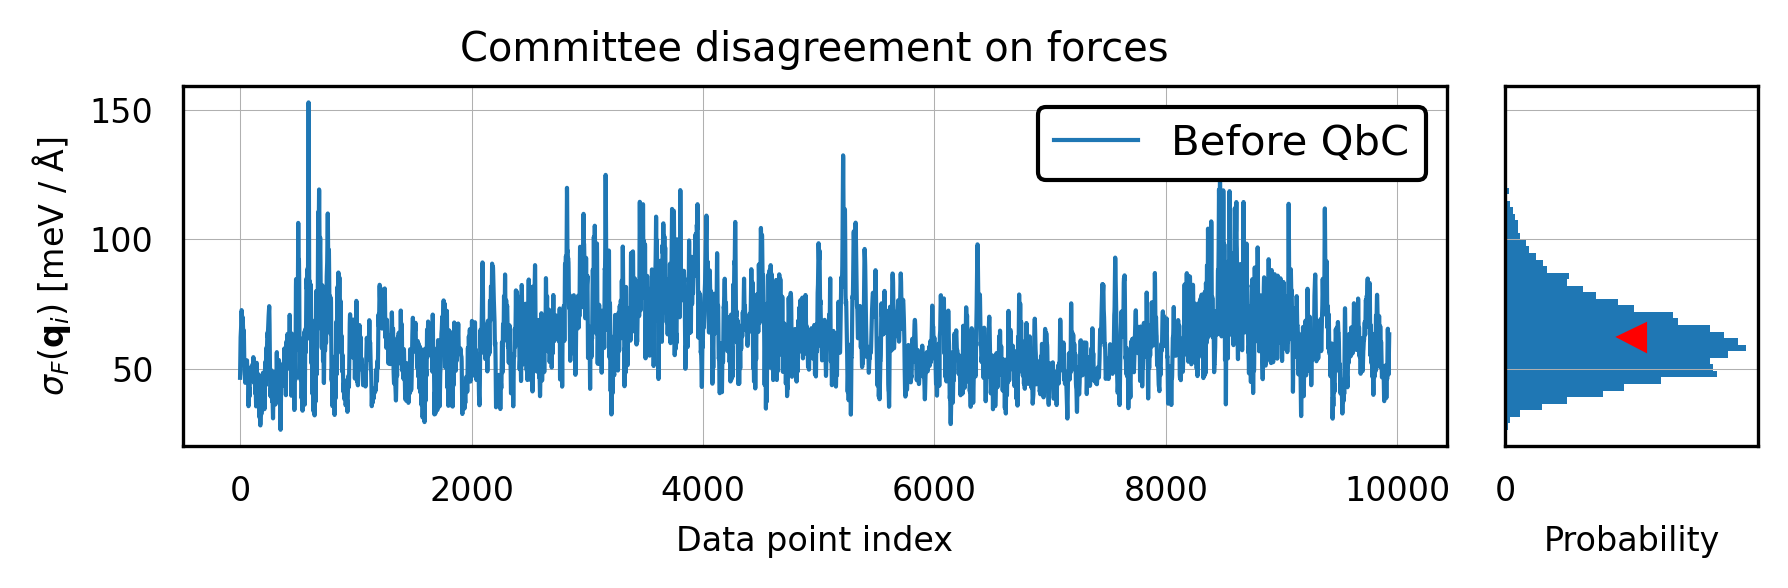

In [17]:
# Predict with all MACE committee members
# README:
# - each model makes predictions on the same candidate structures
# - predictions are saved in separate files, one per model
# - we will later compare these predictions to measure model uncertainty ("disagreement")

# --------------------------------
# Evaluation (it might take time)
# --------------------------------
os.makedirs(f'{init_train_folder}/eval',exist_ok=True)
for n in tqdm(range(n_committee)):
    ofile = f'{init_train_folder}/eval/train_{n:02d}.extxyz'
    if not os.path.exists(ofile):
        eval_mace(f'{init_train_folder}/models/mace.com={n:d}_compiled.model', # compiled model file
                'init-train/structures/candidates.extxyz',                     # input structures
                ofile)                                                         # output prediction file

# load predicted forces from each model into a (n_committee, N_atoms, 3) array
forces = np.array([extxyz2array(f'{init_train_folder}/eval/train_{n:02d}.extxyz', keyword='MACE_forces') 
                   for n in tqdm(range(n_committee))])

# average over atoms to get a single disagreement value per structure
disagreement = {}
disagreement['before qbc'] = 1000*forces2disagreement(forces) # eV to meV conversion

# ------------------------------
# Plotting
# ------------------------------

# create a 2-panel plot: (1) disagreement vs structure index, (2) histogram of disagreements
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))

# plot disagreement curve
ax[0].plot(disagreement['before qbc'], label='Before QbC')
ax[0].set_ylabel(r'$\sigma_F \left(\mathbf{q}_i\right)$ [meV / $\mathrm{\AA}$]')  # y-axis label: std. dev. of force
ax[0].set_xlabel('Data point index')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')
ax[0].legend()

# plot histogram of disagreement values
ax[1].hist(disagreement['before qbc'], bins=50, orientation='horizontal', density=True)
xlim = ax[1].get_xlim()  # get x-axis limits for the histogram
ax[1].plot(xlim[1]/2., disagreement['before qbc'].mean(), '<', c='r')  # show average with a red triangle
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])  # only show one tick on x-axis for a clean look

plt.tight_layout()
if save_image: plt.savefig('images/init-train.disagreement.png',dpi=300,bbox_inches='tight')
plt.show()


## 2. Query by Committee (QbC)

At this point, we have an initial committee model that can predict $\sigma_F$ for arbitrary data points from the remaining candidate pool.

With this ability in our hands, we can now proceed to the actual execution of the QbC procedure.

There one iteratively predicts $\sigma_F$ over the remaining candidate pool, selects a fixed number of candidate geometries that feature the **highest** $\sigma_F$ and adds them to the training set and retrains the committee.

If you are curious about a detailed insight, have a look at the function `run_qbc()` contained in the `myfunctions.py` file. 

<figure style="text-align: center;">
    <img src="images/QbC.png" alt="QbC diagram" style="width: 100%; max-width: 400px;">
    <figcaption style="font-style: italic; font-size: 90%;">
        Schematic representation of Query by Committee (QbC) active learning scheme, 
        showing the candidate pool and training pool selected based on committee uncertainty.
    </figcaption>
</figure>

## 2.1 Run QbC

In [19]:
# Run QbC

os.makedirs(qbc_folder, exist_ok=True)
os.makedirs(f'{qbc_folder}/config', exist_ok=True)

for i in range(n_committee):
    filename = f"{qbc_folder}/config/config.{i}.yml"
    
    prepare_train_file(template="train-template.yaml",
                        output_path=filename,
                        replacements={
                            "NAME" : f"mace.com={i}",
                            "TRAIN_FOLDER" : qbc_folder,
                            "SEED" : seeds[i],
                            "RESTART" : True,
                            "TRAIN_FILE":f"{qbc_folder}/train-iter.extxyz",
                            "DTYPE":"float32"
                        })

    print(f"Wrote '{filename}'")

Wrote 'qbc-work/config/config.0.yml'

Wrote 'qbc-work/config/config.1.yml'

Wrote 'qbc-work/config/config.2.yml'

Wrote 'qbc-work/config/config.3.yml'

In [ ]:
# run Query by Committee (QbC) to iteratively select structures
run_qbc(
    init_train_folder=init_train_folder,
    init_train_file=f"{init_train_folder}/structures/init.train.extxyz", # initial training dataset
    test_dataset=f'{init_train_folder}/structures/test.extxyz',          # test dataset (optional)
    fn_candidates=f'{init_train_folder}/structures/candidates.extxyz',   # candidates pool
    n_iter=n_iter_qbc,                                                   # number of QbC iterations
    n_add_iter=n_add_iter,                                               # number of structures to add in each iteration
    config=f'{qbc_folder}/config',                                       # folder with config files to train MACE models
    ofolder=qbc_folder,                                                  # folder where to save the QbC results
    recalculate_selected=False,                                          # whether to recalculate the selected structures with DFT (part 2 only, False here)
    parallel=False                                                    # whether to parallelize the training and evaluation (this should work for Linux)
);
# it should take 15m

# README: have a look at 'qbc-work'/disagreement.txt

### 2.2 Monitoring QbC convergence

How does one know when the QbC cycle has converged? Simply setting a threshold value for $\sigma_F$ is not the best idea since one does not *a priori* know what it should be.

A better way to look at it is to consider the QbC converged once all the *unlearned* information has been extracted from the candidate set and nothing new remains for the committee to learn.

To visualize this, we can plot the evolution of $\sigma_F$ for each new added batch of structures and see how that comes closer to the value of $\sigma_F$ averaged over the candidate pool.

In practice, one will be always selecting from the high-end tail of the disagreement distribution of the candidates, so one stops the QbC once those curves reach a plateau.

#### Forces disagreement

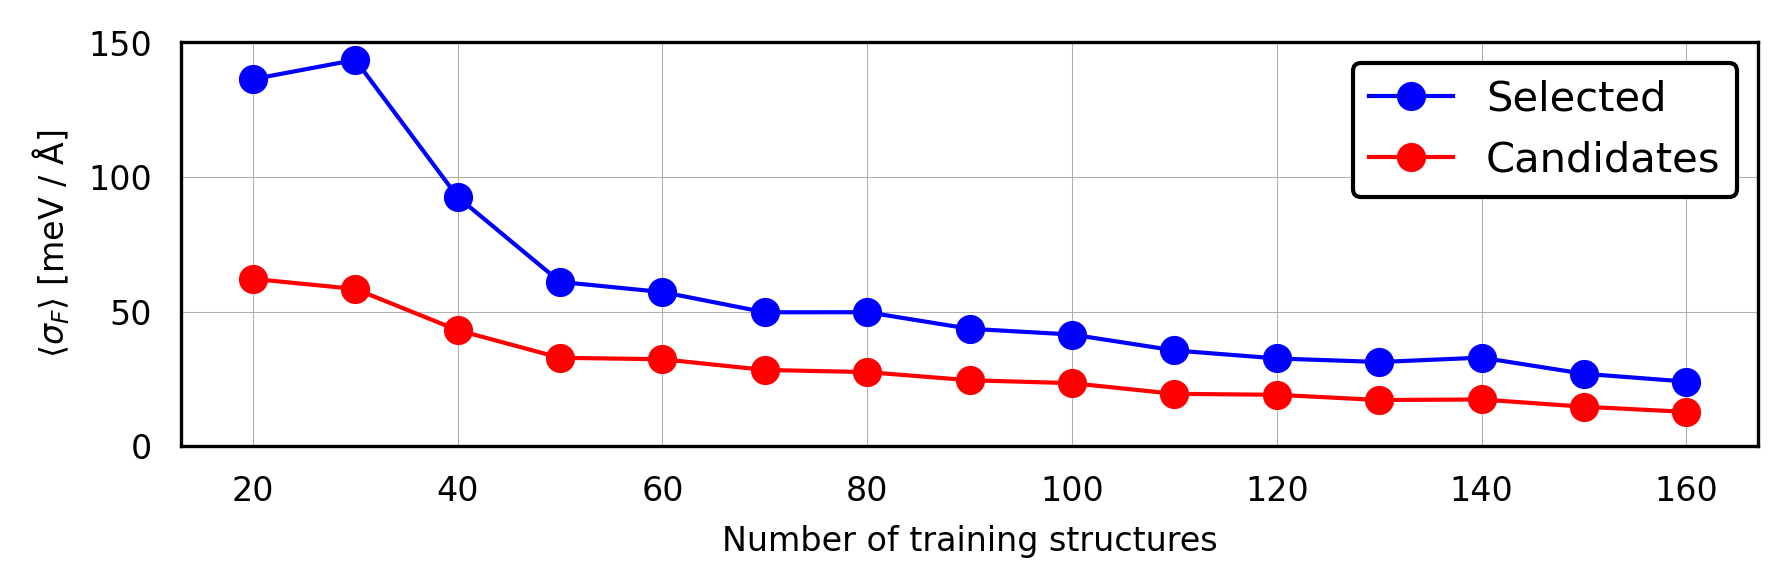

In [ ]:
n_training_structures = np.arange(n_init_train, (n_iter_qbc * n_add_iter) + n_init_train, n_add_iter)
sigma = np.loadtxt('qbc-work/disagreement.txt').T

plt.plot(n_training_structures, sigma[0], '-o', label='Selected', color="blue")
plt.plot(n_training_structures, sigma[1], '-o', label='Candidates', color="red")
plt.legend()
plt.ylim(0, None)
plt.xlabel('Number of training structures')
plt.ylabel(r'$\langle \sigma_F \rangle$ [meV / $\mathrm{\AA}$]')
plt.tight_layout()
if save_image: plt.savefig('images/qbc.disagreement.png',dpi=300,bbox_inches='tight')
plt.show()

#### Generalization error

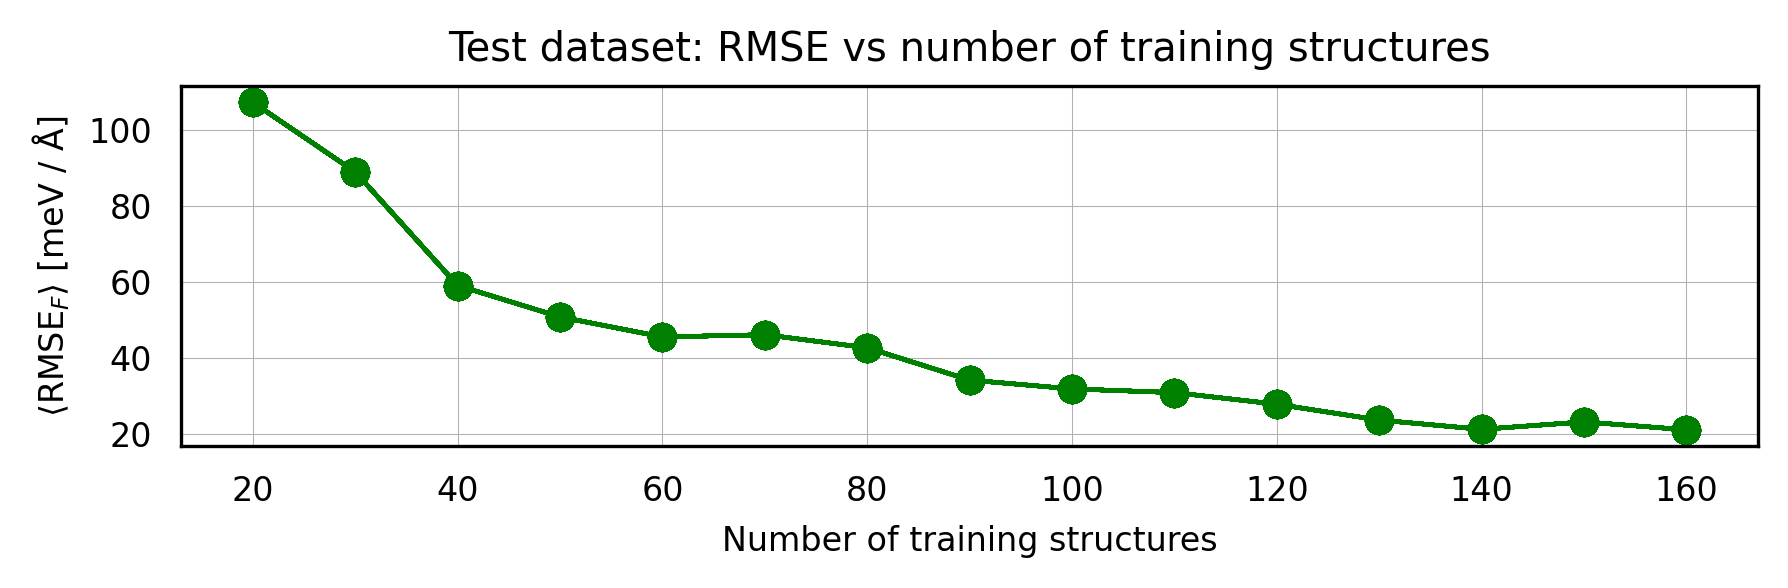

In [ ]:
mace_forces = np.zeros((n_iter_qbc, n_committee, n_test, 7, 3))  # forces for each iteration
ref_forces = extxyz2array(f'{init_train_folder}/structures/test.extxyz', keyword='REF_forces')  # reference forces
assert ref_forces.shape == (n_test, 7, 3)  # check shape of reference forces

for i_iter in range(n_iter_qbc):
    predictions = [None] * n_committee
    for n_model in range(n_committee):
        file = f"{qbc_folder}/eval/test.model={n_model}.iter={i_iter}.extxyz"
        mace_forces[i_iter,n_model,:,:] = extxyz2array(file, keyword='MACE_forces')
# print(mace_forces.shape)  # should be (n_iter_qbc, n_committee, n_test, 7, 3)
assert np.isnan(mace_forces).sum() == 0  # check for NaN values

error = np.zeros((n_iter_qbc,n_test))
error_std = np.zeros((n_iter_qbc,n_test))
for i_iter in range(n_iter_qbc):
    rmse = 1000*forces2rmse(mace_forces[i_iter], ref_forces) # eV to meV conversion
    error[i_iter] = np.mean(rmse)
    error_std[i_iter] = np.std(rmse)
    
n_training_structures = np.arange(n_init_train, (n_iter_qbc * n_add_iter) + n_init_train, n_add_iter)
plt.plot(n_training_structures, error, "-o", color="green")
plt.title("Test dataset: RMSE vs number of training structures")
plt.xlabel('Number of training structures')
plt.ylabel(r'$\langle \text{RMSE}_F \rangle$ [meV / $\mathrm{\AA}$]')
plt.tight_layout()
if save_image: plt.savefig('images/qbc.gen-err.png',dpi=300,bbox_inches='tight')
plt.show()

### Correlation between disgreement and generalization error

Here, we will demonstrate that $\sigma_F$ is a *measure* of uncertainty, but is not equivalent to the **generalization error**, *i.e.*, the actual error of the model in prediction performed on previously unseen data.

In order to do this, we do an identical exercise as before: we let the committee predict on the remaining candidate structures, which will give us the predicted forces from which we derive the disagreement $\sigma_F$.

Then, since the initial candidate set is labeled, we take the **reference forces** and calculate the generalization as the RMSE
$$
\text{RMSE}_F\left(\mathbf{q}_i\right) =
\sqrt{\frac{1}{N} \sum_{\alpha=1}^{N} \left( \overline{\mathbf{F}}_\alpha - \mathbf{F}_\alpha^\text{ref} \right)^2}
$$

and simply correlate the two quantities.

In [ ]:
# Load reference forces
ref_forces_test = np.array(extxyz2array(f'{init_train_folder}/structures/test.extxyz', keyword='REF_forces'))

# Preload all predictions
all_sigma_test = []
all_rmse_test = []

XLIM = (0, 150)  # x-axis limits for the plots
YLIM = (0, 150)   # y-axis limits for the plots
XTICKS = [0,50,100,150]

for iteration in range(n_iter_qbc):
    mace_forces_test = np.array([
        extxyz2array(f"{qbc_folder}/eval/test.model={n}.iter={iteration}.extxyz", keyword='MACE_forces')
        for n in range(n_committee)
    ])
      
    # Test metrics
    sigma_test = 1000 * forces2disagreement(mace_forces_test)
    rmse_test = 1000 * forces2rmse(mace_forces_test, ref_forces_test)
    all_sigma_test.append(sigma_test)
    all_rmse_test.append(rmse_test)

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_corr(iteration):
    sigma = all_sigma_test[iteration]
    rmse = all_rmse_test[iteration]

    # KDE for joint plot
    xy = np.vstack([rmse, sigma])
    kde = gaussian_kde(xy)
    xgrid = np.linspace(*XLIM, 100)
    ygrid = np.linspace(*YLIM, 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Main figure and axis
    fig, ax = plt.subplots()

    # Scatter + contour
    ax.scatter(rmse, sigma, color='blue', s=1)
    levels = np.linspace(Z.min(), Z.max(), 7)[1:]
    ax.contour(X, Y, Z, levels=levels, cmap='Blues', alpha=0.7)

    ax.set_xlim(*XLIM)
    ax.set_xticks(XTICKS)
    ax.set_yticks(XTICKS)
    ax.set_ylim(*YLIM)
    ax.set_title(f"Iteration {iteration}: Committee Disagreement vs RMSE (Test)")
    ax.set_xlabel(r'RMSE$_F(\mathbf{q}_i)$ [meV / $\mathrm{\AA}$]')
    ax.set_ylabel(r'$\sigma_F(\mathbf{q}_i)$ [meV / $\mathrm{\AA}$]')
    # ax.legend(loc='upper left')

    # Inset axis for marginal distributions
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper left', borderpad=1)

    # Distributions (KDE)
    rmse_kde = gaussian_kde(rmse)
    sigma_kde = gaussian_kde(sigma)
    rmse_grid = np.linspace(*XLIM, 200)
    sigma_grid = np.linspace(*YLIM, 200)

    ax_inset.plot(rmse_grid, rmse_kde(rmse_grid), color='blue', linestyle="dotted", label=r'RMSE$_F$' )
    ax_inset.plot(sigma_grid, sigma_kde(sigma_grid), color='blue', linestyle="dashed", label=r'$\sigma_F$')

    ax_inset.set_xlim(*XLIM)
    ax_inset.set_xticks(XTICKS)
    ax_inset.set_yticks([])
    # ax_inset.set_title("Marginal KDEs", fontsize=8)
    ax_inset.legend(fontsize=6, loc='upper right', frameon=False)

    # Save and show
    # plt.tight_layout()
    plt.savefig(f'images/qbc.corr.iter={iteration}.png', dpi=300, bbox_inches='tight')
    plt.show()



# Slider for iteration
interact(plot_corr, iteration=IntSlider(min=0, max=n_iter_qbc - 1, step=1, value=0, description='Iteration'))


interactive(children=(IntSlider(value=0, description='Iteration', max=14), Output()), _dom_classes=('widget-in…

<function __main__.plot_corr(iteration)>

A correlation is clear. This makes sense, since the two quantities are related by their physical meaning, but they are nowhere near identical.

## 3. Comparison of active learning and random data point selection

In [6]:
# Prepare the random training folders
os.makedirs(f'{random_train_folder}', exist_ok=True)                # initial training folder
os.makedirs(f'{random_train_folder}/config', exist_ok=True)         # folder with the config files used for training the MACE models
os.makedirs(f'{random_train_folder}/models', exist_ok=True)         # folder with the (final) trained MACE models
os.makedirs(f'{random_train_folder}/eval', exist_ok=True)           # folder where we will save the evaluation results

# read the labeled structures from the extxyz file
structures = read('../initial-datasets/zundel/train.extxyz', index=':')
print(f'Total number of structures: {len(structures)}')

# Create the initial training datasets
random_indices = np.random.choice(len(structures), 170, replace=False)

# Random dataset
print(f"\nSelected indices for training:\n{random_indices}")
random_training_set = [structures[i] for i in random_indices]
print(f"Saving the random training dataset to '{random_train_folder}/random.train.extxyz'")
write(f'{random_train_folder}/random.train.extxyz', random_training_set, format='extxyz')

Total number of structures: 10001

Selected indices for training:
[9058  836 3726 4499 8675 7117  377  651 9588 2030 9458 1091  915  834
 6495 5335  693 1103 5514 7983 4540 6721 6805 6845 1585 8168 5882 6935
 5657 2576 2436 1835  382 1478 3439 3634 6682 9694 1240 7605 2836 1597
 6154 7688 3051 8267 2613 3086 3381 3885 2006 9938 4855  256 3761 5579
 7621 9460 6018 7538 1421 1312 9630 2933 7784 3864 4589 6443 3944 2940
  167 8789 6224 6788 5571 2501 8232 7989 1507 1261 6614 3910 2767 6973
 8611 6825 3847  578 4960 3009 9652 4277 7386  226 7178 7353 5624  841
 3691 3682  974 9984 7756 9866 7369 9768 9828 4138 2520 5466 7514 5855
 9685 7314 4908 8672 2168 9219 4954 6031 1095 7349 2153 3601  843 1035
 7432 8362 4474 2183  598 2587 3581 9032 4495 4920 2380 2446 4626 9232
  580 4804 9075 5770 2500 2016 8333 7835 2890 4339 9679 1455 1379 2607
 8549 3842 7552 2513 8898 1718 2272 5486 4779 7617 1373 6771  272 9275
 8724 3557]

Saving the random training dataset to 'random-train/random.train.extxyz'

In [7]:
# prepare the config files to train the MACE models
# README: 
# - the files will be saved in the 'init-train/config' folder
# - they are built from a template file: 'train-template.yaml'
# - try to have a look at any of these files to see how the MACE models are trained and constructed

template_file = 'train-template.yaml'
print(f"Using template file '{template_file}' to generate:")

for i in range(n_committee):
    filename = f"{random_train_folder}/config/config.{i}.yml"
    
    prepare_train_file( template=template_file,            # template file
                        output_path=filename,              # config file to be created
                        replacements={                     # replacements in the template file
                            "NAME" : f"mace.com={i}",    
                            "SEED" : seeds[i],
                            "TRAIN_FOLDER" : random_train_folder,
                            "RESTART" : False,
                            "TRAIN_FILE":f"{random_train_folder}/random.train.extxyz",
                            "DTYPE":"float32"
                        })

    print(f"\t - '{filename}'")

Using template file 'train-template.yaml' to generate:

- 'random-train/config/config.0.yml'

- 'random-train/config/config.1.yml'

- 'random-train/config/config.2.yml'

- 'random-train/config/config.3.yml'

In [ ]:
# train a committee of MACE models
# README:
# - each model is trained from a different config file (created earlier)
# - models are trained either in parallel (faster) or serial (simpler/debuggable)
# - once training is done, the resulting model files are deleted to save space

#-------------------------#
def train_single_model(n):
    """ Trains a single model using its config file"""
    train_mace(f"{random_train_folder}/config/config.{n}.yml")

#-------------------------#
parallel = False
if parallel:  # parallel version: should take ~20s
    try:
        import multiprocessing  # use multiprocessing for faster training
    except ImportError as err:
        # if multiprocessing is not available, notify user and raise the error
        print("Parallel processing is not available. Please set 'parallel' to False.")
        raise err

    print(f"Training {n_committee} models in parallel")
    # train models concurrently using all available CPU cores
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(train_single_model, range(n_committee))

#-------------------------#
else:  # serial version: should take ~1m
    print(f"Training {n_committee} models in serial")
    # train models one-by-one in a loop
    for n in range(n_committee):
        print(f"Training model {n}")
        train_single_model(n)

#-------------------------#
# cleanup: remove individual model files after training (optional)
# this is useful only for saving space, as the models are already saved in the 'models' folder as '*_compiled.model' files
for n in range(n_committee):
    os.remove(f"{random_train_folder}/models/mace.com={n}.model")


Training 4 models in serial

Training model 0

Training model 1

Training model 2

Training model 3

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

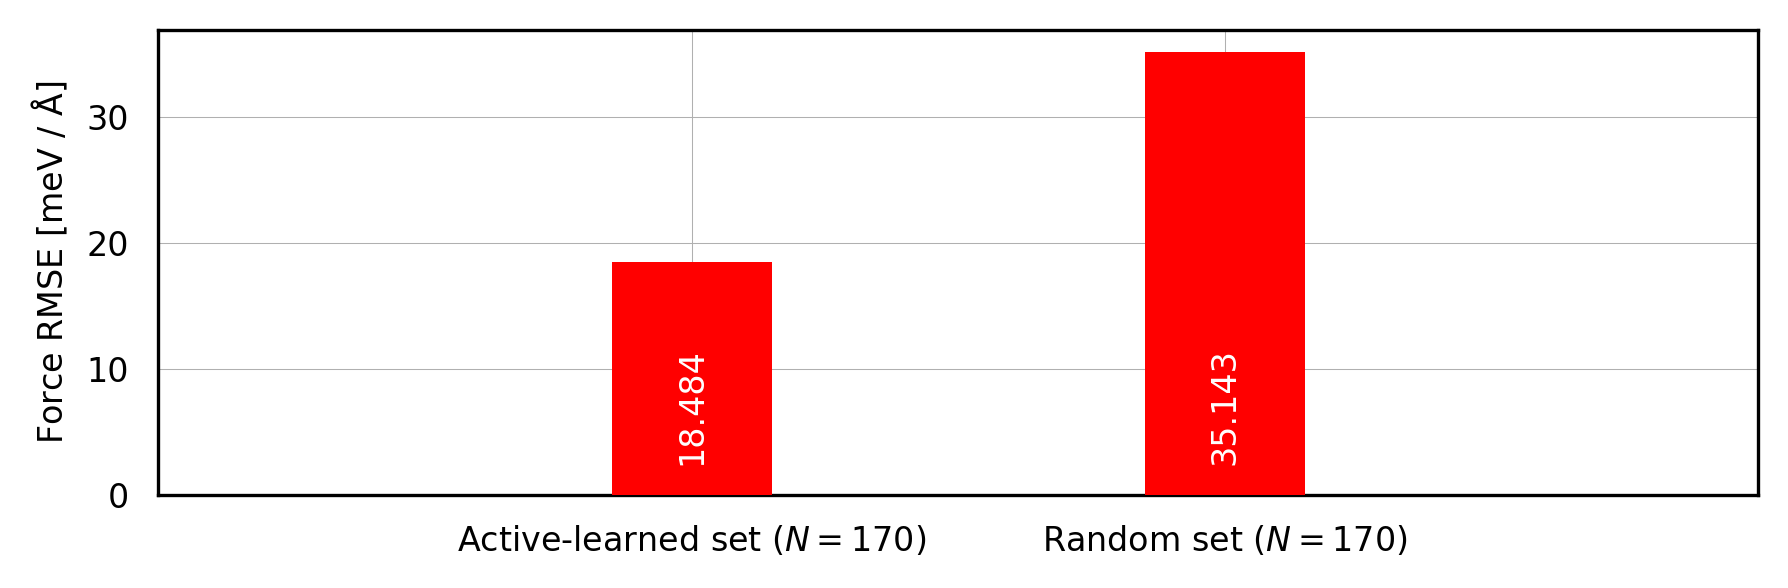

In [8]:
# evaluate random model
for n in tqdm(range(n_committee)):
    eval_mace(f'{random_train_folder}/models/mace.com={n:d}_compiled.model',   # compiled model file
              'init-train/structures/test.extxyz',                     # input structures
              f'{random_train_folder}/eval/random.test_{n:02d}.extxyz') 

# evaluate active-learned model
for n in tqdm(range(n_committee)):
    eval_mace(f'{qbc_folder}/models/mace.com={n:d}_compiled.model',   # compiled model file
              'init-train/structures/test.extxyz',                     # input structures
              f'{random_train_folder}/eval/AL.test_{n:02d}.extxyz') 

forces = extxyz2array('init-train/structures/test.extxyz', keyword='REF_forces')

mace_forces_rand = np.array([
    extxyz2array(f'{random_train_folder}/eval/random.test_{n:02d}.extxyz', keyword='MACE_forces')
    for n in tqdm(range(n_committee))
])

mace_forces_active = np.array([
    extxyz2array(f'{random_train_folder}/eval/AL.test_{n:02d}.extxyz', keyword='MACE_forces')
    for n in tqdm(range(n_committee))
])

rmse_random = 1000 * forces2rmse(mace_forces_rand, forces).mean()
rmse_active = 1000 * forces2rmse(mace_forces_active, forces).mean()

plt.bar([0, 1], [rmse_active, rmse_random], width=0.3, zorder=10, color='r')
plt.xlim(-1, 2)
plt.grid(zorder=0)
plt.xticks(np.arange(-1, 3), labels=['', 'Active-learned set ($N =$170)', 'Random set ($N = $170)', ''])
plt.ylabel(r'Force RMSE [meV / $\mathrm{\AA}$]')
plt.text(0, 7, f'{rmse_active:.03f}', c='w', ha='center', va='center', zorder=101, rotation=90)
plt.text(1, 7, f'{rmse_random:.03f}', c='w', ha='center', va='center', zorder=101, rotation=90)
plt.tight_layout()
if save_image: plt.savefig("images/AL-vs-random.png",dpi=300,bbox_inches='tight')
plt.show()